### Dependencies

In [ ]:
# Dependencies
%pip install google-generativeai numpy python-dotenv openai

### Libraries

In [ ]:
# Libraries
import google.generativeai as genai
import openai
import numpy as np
import time
import re
import random
import traceback
import sys
import os
import matplotlib.pyplot as plt
import importlib.util
from dotenv import load_dotenv

# For Gemini API key
load_dotenv()

True

### Configuration

In [ ]:
# Gemini Setup (API)
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
GEMINI_MODEL = "gemini-2.5-flash" 

# DeepSeek Setup (local API, LM Studio)
LOCAL_BASE_URL = "http://localhost:1234/v1" 
LOCAL_API_KEY = "lm-studio"
LOCAL_MODEL = "deepseek-r1-distill-qwen-7b-tir-o3-mini-code"

### Evaluator

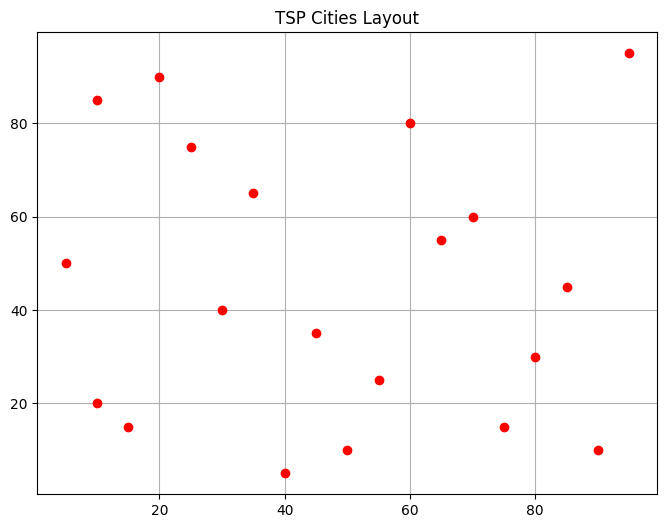

In [ ]:
class TSPEvaluator:
    def __init__(self):
        # Standard TSP instance setup
        self.num_cities = 20
        self.coordinates = np.array([
            [10.0, 20.0], [30.0, 40.0], [50.0, 10.0], [60.0, 80.0], [20.0, 90.0],
            [15.0, 15.0], [45.0, 35.0], [55.0, 25.0], [70.0, 60.0], [80.0, 30.0],
            [25.0, 75.0], [35.0, 65.0], [90.0, 10.0], [5.0, 50.0], [10.0, 85.0],
            [95.0, 95.0], [40.0, 5.0],  [65.0, 55.0], [75.0, 15.0], [85.0, 45.0]
        ])
        self.dist_matrix = self._calculate_distance_matrix()  # Precompute distances

    def _calculate_distance_matrix(self):
        # Euclidean distance between all city pairs
        n = self.num_cities
        matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                dist = np.linalg.norm(self.coordinates[i] - self.coordinates[j])
                matrix[i][j] = dist
        return matrix

    def evaluate(self, route):
        # Return total tour length or inf if invalid
        if not isinstance(route, list) or len(route) != self.num_cities:
            return float('inf') 
        if len(set(route)) != self.num_cities:
            return float('inf')

        cost = 0.0
        for i in range(len(route)):
            from_city = route[i]
            to_city = route[(i + 1) % len(route)]
            cost += self.dist_matrix[from_city][to_city]
        return cost

    def get_data(self):
        # Return distance matrix
        return self.dist_matrix
        
    def plot_route(self, route, title="Route"):
        # Visualize cities and optionally a tour
        plt.figure(figsize=(8, 6))
        plt.scatter(self.coordinates[:, 0], self.coordinates[:, 1], c='red', zorder=2)
        
        if route and len(route) == self.num_cities:
            path_coords = self.coordinates[route + [route[0]]] # Close the loop
            plt.plot(path_coords[:, 0], path_coords[:, 1], 'b-', zorder=1)
            
        plt.title(title)
        plt.grid(True)
        plt.show()

# Visualize city layout only
evaluator_viz = TSPEvaluator()
evaluator_viz.plot_route([], title="TSP Cities Layout")

### LLM Client

In [ ]:
class LLMClient:
    def __init__(self, provider):
        # Initialize LLM client with provider-specific configuration
        self.provider = provider
        # System instructions define strict novelty, interface, and constraints for TSP heuristic generation
        self.system_instructions = """
        You are an Operations Research scientist tasked with inventing a structurally novel heuristic algorithm for the Traveling Salesman Problem (TSP).
        ...
        """

        if provider == "GEMINI":
            # Configure Gemini API
            genai.configure(api_key=GEMINI_API_KEY)
            self.model = genai.GenerativeModel(GEMINI_MODEL)
        elif provider == "LOCAL":
            # Configure local OpenAI-compatible API
            self.client = openai.OpenAI(base_url=LOCAL_BASE_URL, api_key=LOCAL_API_KEY)

    def generate_code(self, current_code, current_score, feedback=""):
        # Build prompt including system instructions, current best code and score, and feedback
        prompt = f"""
        {self.system_instructions}

        CURRENT BEST SCORE (Total Distance): {current_score:.2f} (Lower is better)
        
        CURRENT CODE:
        ```python
        {current_code}
        ```

        FEEDBACK FROM PREVIOUS ATTEMPT:
        {feedback}

        TASK:
        Invent a new heuristic or refine the current one to beat the current score.
        The heuristic must by novel and innovative.
        Provide the full updated Python code.
        """
        
        try:
            if self.provider == "GEMINI":
                # Call Gemini LLM and extract Python code
                response = self.model.generate_content(prompt)
                return self._clean_response(response.text)
            elif self.provider == "LOCAL":
                # Call local model with chat-completion interface
                response = self.client.chat.completions.create(
                    model=LOCAL_MODEL,
                    messages=[
                        {"role": "system", "content": self.system_instructions},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.7
                )
                return self._clean_response(response.choices[0].message.content)
        except Exception as e:
            print(f"[LLM Error]: {e}")
            return None

    def _clean_response(self, text):
        # Extract Python code from markdown-formatted response
        match = re.search(r"```python(.*?)```", text, re.DOTALL)
        if match:
            return match.group(1).strip()
        match = re.search(r"```(.*?)```", text, re.DOTALL)  # Generic code block fallback
        if match:
            return match.group(1).strip()
        return text.strip()


### Discovery Engine

In [13]:
class HeuristicDiscoveryEngine:
    def __init__(self, provider):
        self.evaluator = TSPEvaluator()
        self.llm = LLMClient(provider)
        self.best_code = self._get_initial_code()
        self.best_score = float('inf')
        
    def _get_initial_code(self):
        return """
import random
import numpy as np

def solve_tsp(distance_matrix):
    # Initial Basic Solution: Random Shuffle
    n = len(distance_matrix)
    route = list(range(n))
    random.shuffle(route)
    return route
"""

    def _unsafe_execute_and_score(self, code_str):
        local_scope = {}
        global_scope = {
            "np": np,
            "random": random,
            "math": __import__('math'),
            "re": re,
            "sys": sys
        }
        try:
            exec(code_str, global_scope, local_scope)
            
            if 'solve_tsp' not in local_scope:
                return float('inf'), "Function 'solve_tsp' missing."

            solver_func = local_scope['solve_tsp']
            data = self.evaluator.get_data()
            
            route = solver_func(data)
            score = self.evaluator.evaluate(route)
            
            return score, None, route # Return route for plotting
        except Exception as e:
            error_message = f"{str(e)}\n{traceback.format_exc()}"
            return float('inf'), error_message, None

    def run_optimization(self, iterations=5):
        print(f"--- Starting Heuristic Discovery Process ({self.llm.provider}) ---")
        
        # Evaluate Seed
        score, _, route = self._unsafe_execute_and_score(self.best_code)
        self.best_score = score
        print(f"Iteration 0 (Seed) | Score: {self.best_score:.2f}")
        
        # Plot initial
        if route:
            self.evaluator.plot_route(route, title=f"[{self.llm.provider}] Initial Random Route (Score: {score:.2f})")

        last_error = None
        history_scores = [score]

        for i in range(1, iterations + 1):
            print(f"\nProcessing Iteration {i}...")
            
            feedback = (
                f"Current best score is {self.best_score:.2f}. "
                "Improve solution quality while respecting the novelty constraints. "
                "If progress stagnates, introduce a fundamentally different mechanism "
                "using new state variables or historical memory."
            )


            if last_error:
                feedback = f"PREVIOUS CODE FAILED. Fix this error:\n{last_error}"

            new_code = self.llm.generate_code(self.best_code, self.best_score, feedback)

            if not new_code:
                print("Skipping iteration due to generation error.")
                continue

            new_score, error, new_route = self._unsafe_execute_and_score(new_code)

            if error:
                print(f"Code Execution Failed: {error.splitlines()[0]}...")
                last_error = error
            else:
                last_error = None
                print(f"New Score: {new_score:.2f} | Best Previous: {self.best_score:.2f}")
                
                if new_score < self.best_score:
                    print(">>> IMPROVEMENT FOUND! Updating best heuristic.")
                    self.best_score = new_score
                    self.best_code = new_code
                    # Plot improvement
                    if new_route:
                        self.evaluator.plot_route(new_route, title=f"[{self.llm.provider}] Iteration {i} (Score: {new_score:.2f})")
                else:
                    print("No improvement.")
            
            history_scores.append(self.best_score)

        return self.best_code, self.best_score, history_scores


### Gemini Experiment

Running with: gemini-2.5-flash
--- Starting Heuristic Discovery Process (GEMINI) ---
Iteration 0 (Seed) | Score: 1065.42


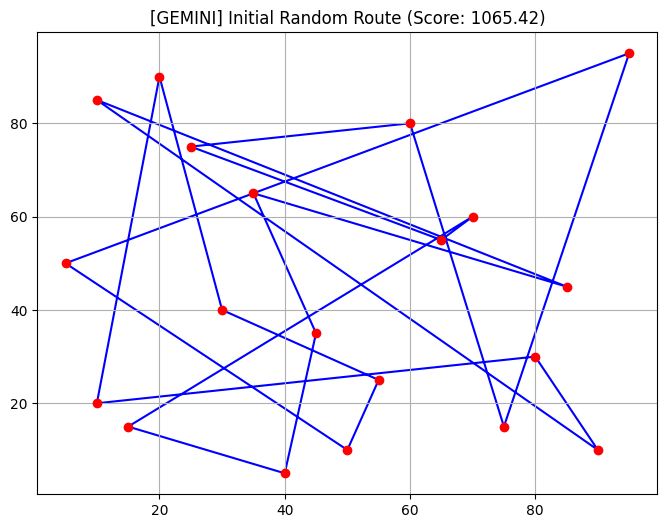


Processing Iteration 1...
Code Execution Failed: name 'collections' is not defined...

Processing Iteration 2...
Code Execution Failed: name 'defaultdict' is not defined...

Processing Iteration 3...
New Score: 446.43 | Best Previous: 1065.42
>>> IMPROVEMENT FOUND! Updating best heuristic.


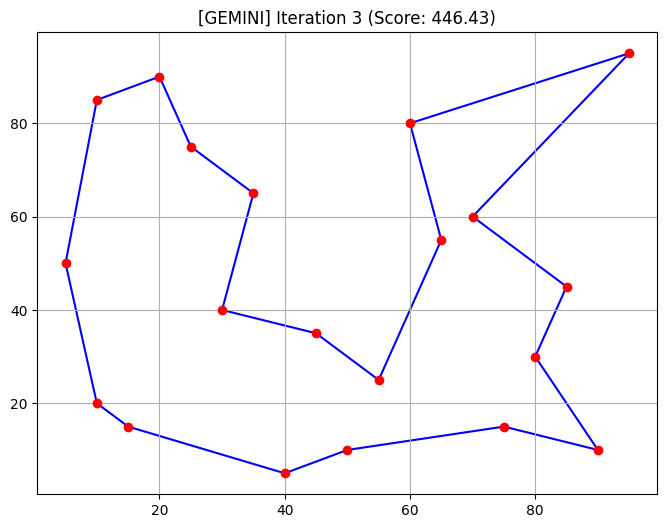


Processing Iteration 4...
New Score: 440.90 | Best Previous: 446.43
>>> IMPROVEMENT FOUND! Updating best heuristic.


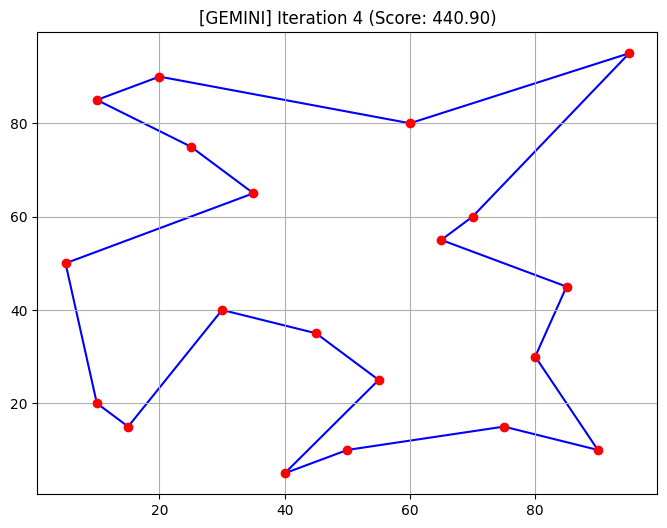


Processing Iteration 5...
New Score: 432.33 | Best Previous: 440.90
>>> IMPROVEMENT FOUND! Updating best heuristic.


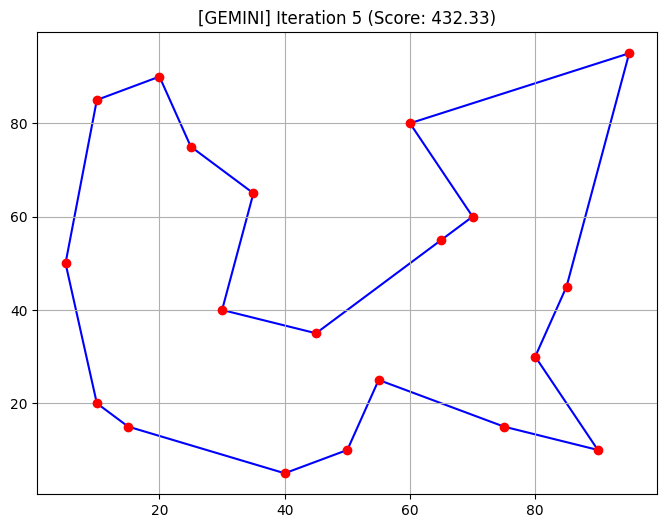


Processing Iteration 6...
New Score: 452.15 | Best Previous: 432.33
No improvement.

Processing Iteration 7...
New Score: 432.33 | Best Previous: 432.33
>>> IMPROVEMENT FOUND! Updating best heuristic.


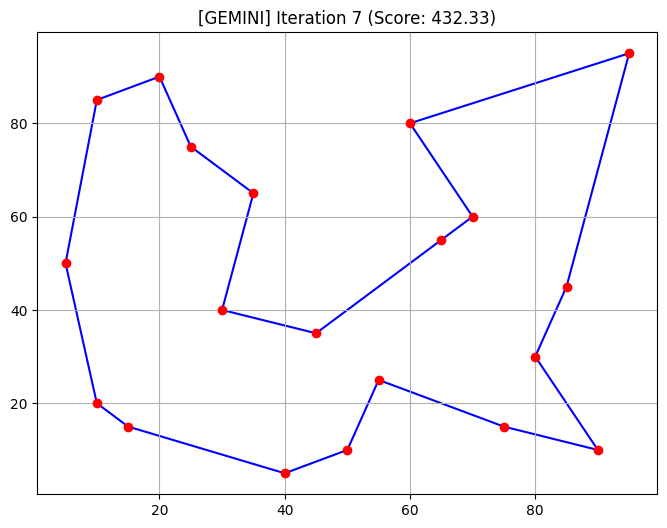


Processing Iteration 8...
New Score: 428.42 | Best Previous: 432.33
>>> IMPROVEMENT FOUND! Updating best heuristic.


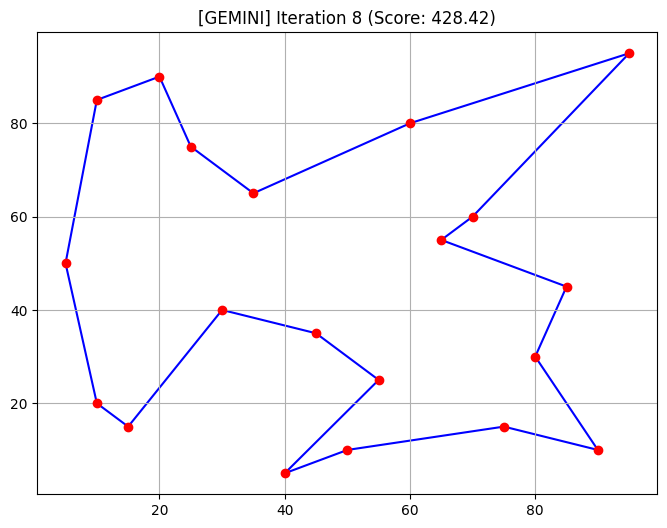


Processing Iteration 9...
Code Execution Failed: name 'generate_permutations' is not defined...

Processing Iteration 10...
New Score: 434.11 | Best Previous: 428.42
No improvement.

Processing Iteration 11...
New Score: 432.33 | Best Previous: 428.42
No improvement.

Processing Iteration 12...
New Score: 432.33 | Best Previous: 428.42
No improvement.

Processing Iteration 13...
New Score: 458.72 | Best Previous: 428.42
No improvement.

Processing Iteration 14...
New Score: 1049.37 | Best Previous: 428.42
No improvement.

Processing Iteration 15...
New Score: 432.33 | Best Previous: 428.42
No improvement.

Processing Iteration 16...
New Score: 673.73 | Best Previous: 428.42
No improvement.

Processing Iteration 17...
New Score: 463.92 | Best Previous: 428.42
No improvement.

Processing Iteration 18...
New Score: 712.49 | Best Previous: 428.42
No improvement.

Processing Iteration 19...
New Score: 432.33 | Best Previous: 428.42
No improvement.

Processing Iteration 20...
New Score: 438

In [ ]:
# Start optimization using Gemini LLM
print(f"Running with: {GEMINI_MODEL}")

# Initialize the heuristic discovery engine with Gemini provider
engine_gemini = HeuristicDiscoveryEngine("GEMINI")

# Run optimization for 20 iterations, returning best code, score, and history
code_gemini, score_gemini, history_gemini = engine_gemini.run_optimization(iterations=20)

# Display final results
print("\n" + "="*40)
print(f"FINAL GEMINI RESULT (Score: {score_gemini:.2f})")
print("="*40)
print(code_gemini)

# Persist the best solution code to a Python file
with open("best_solver_gemini.py", "w") as f:
    f.write(code_gemini)

print("Best Gemini solver saved to 'best_solver_gemini.py'")

### DeepSeek Experiment

Running with: deepseek-r1-distill-qwen-7b-tir-o3-mini-code
--- Starting Heuristic Discovery Process (LOCAL) ---
Iteration 0 (Seed) | Score: 1092.82


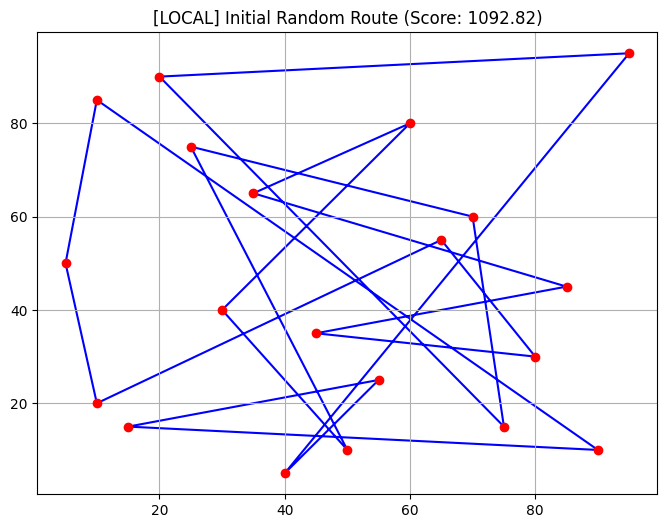


Processing Iteration 1...
Code Execution Failed: unexpected indent (<string>, line 3)...

Processing Iteration 2...
Code Execution Failed: unexpected indent (<string>, line 192)...

Processing Iteration 3...
New Score: inf | Best Previous: 1092.82
No improvement.

Processing Iteration 4...
Code Execution Failed: invalid character '≤' (U+2264) (<string>, line 124)...

Processing Iteration 5...
New Score: 1128.05 | Best Previous: 1092.82
No improvement.

Processing Iteration 6...
Code Execution Failed: unexpected indent (<string>, line 36)...

Processing Iteration 7...
New Score: 1039.35 | Best Previous: 1092.82
>>> IMPROVEMENT FOUND! Updating best heuristic.


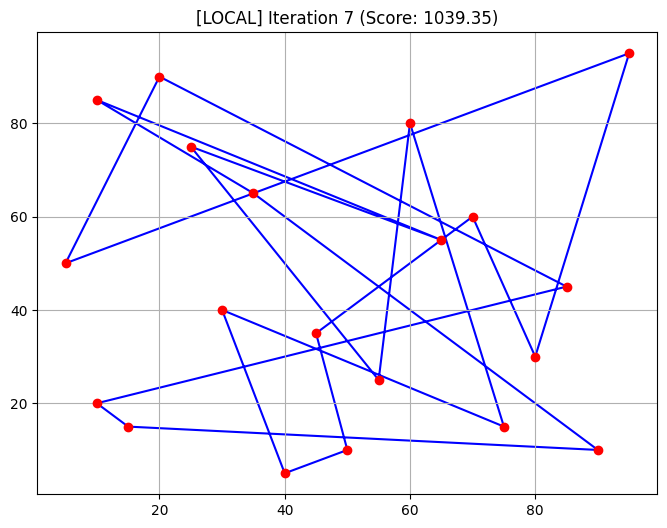


Processing Iteration 8...
Code Execution Failed: unexpected indent (<string>, line 13)...

Processing Iteration 9...
Code Execution Failed: cannot unpack non-iterable int object...

Processing Iteration 10...
New Score: inf | Best Previous: 1039.35
No improvement.

Processing Iteration 11...
Code Execution Failed: cannot access local variable 'best_distance' where it is not associated with a value...

Processing Iteration 12...
New Score: 937.08 | Best Previous: 1039.35
>>> IMPROVEMENT FOUND! Updating best heuristic.


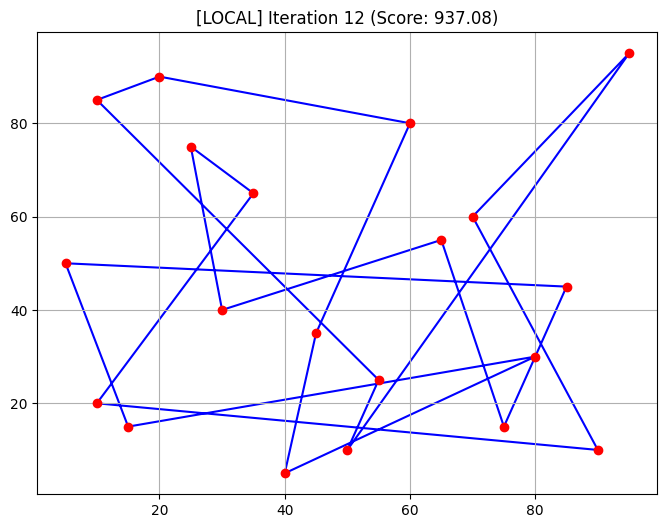


Processing Iteration 13...
Code Execution Failed: unexpected indent (<string>, line 29)...

Processing Iteration 14...
Code Execution Failed: name 'compute_total_distance' is not defined...

Processing Iteration 15...
New Score: 1087.87 | Best Previous: 937.08
No improvement.

Processing Iteration 16...
New Score: 556.45 | Best Previous: 937.08
>>> IMPROVEMENT FOUND! Updating best heuristic.


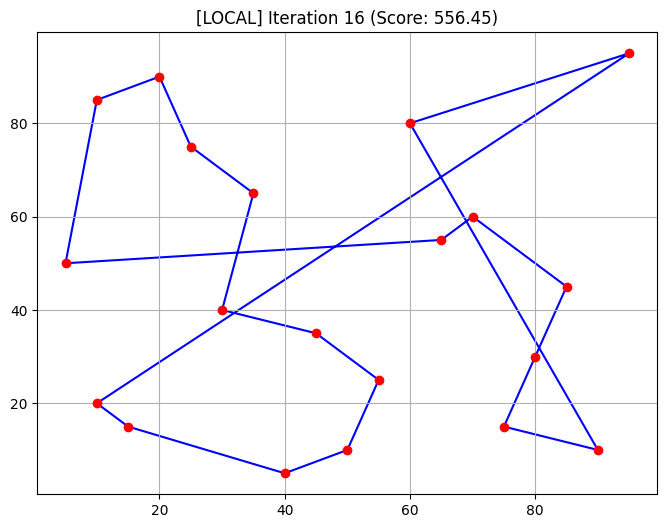


Processing Iteration 17...
New Score: inf | Best Previous: 556.45
No improvement.

Processing Iteration 18...
New Score: inf | Best Previous: 556.45
No improvement.

Processing Iteration 19...
New Score: 480.12 | Best Previous: 556.45
>>> IMPROVEMENT FOUND! Updating best heuristic.


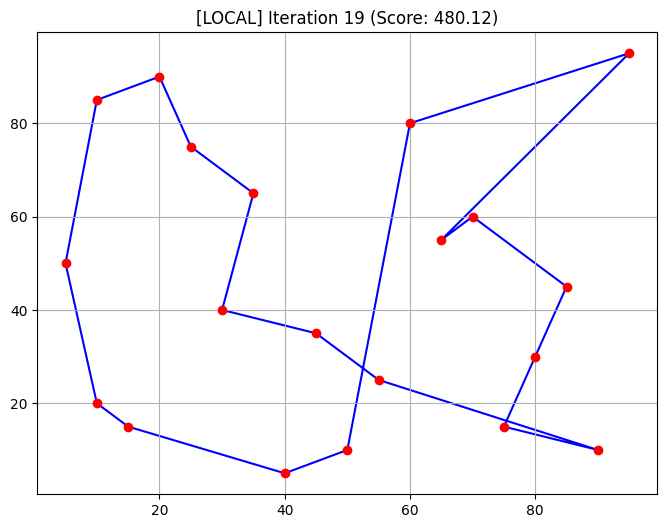


Processing Iteration 20...
New Score: 914.90 | Best Previous: 480.12
No improvement.

FINAL DEEPSEEK RESULT (Score: 480.12)
import random
import math
import numpy as np

def solve_tsp(distance_matrix):
    n = len(distance_matrix)
    
    # Start at a random city; here we use np.random.choice with replacement=True.
    route = [random.choice(range(n))]
    visited = set([route[0]])
    
    while len(route) < n:
        last_city = route[-1]
        best_candidate = None
        best_cost = float('inf')
        
        for candidate in range(n):
            if candidate not in visited:
                # Compute Euclidean distance from the last city.
                dist = math.sqrt(distance_matrix[last_city][candidate]**2)
                
                # Introduce a repulsion penalty when the candidate is too close to the current city.
                # For example, if the distance is below a threshold (5.0), add a penalty of 100 * dist.
                repulsion = 100 * dist if 

In [ ]:
# Start optimization using Local DeepSeek LLM
print(f"Running with: {LOCAL_MODEL}")

# Initialize the heuristic discovery engine with LOCAL provider
engine_local = HeuristicDiscoveryEngine("LOCAL")

# Run optimization for 20 iterations, returning best code, score, and history
code_local, score_local, history_local = engine_local.run_optimization(iterations=20)

# Display final results
print("\n" + "="*40)
print(f"FINAL DEEPSEEK RESULT (Score: {score_local:.2f})")
print("="*40)
print(code_local)

# Persist the best solution code to a Python file
with open("best_solver_deepseek.py", "w") as f:
    f.write(code_local)

### Benchmarking

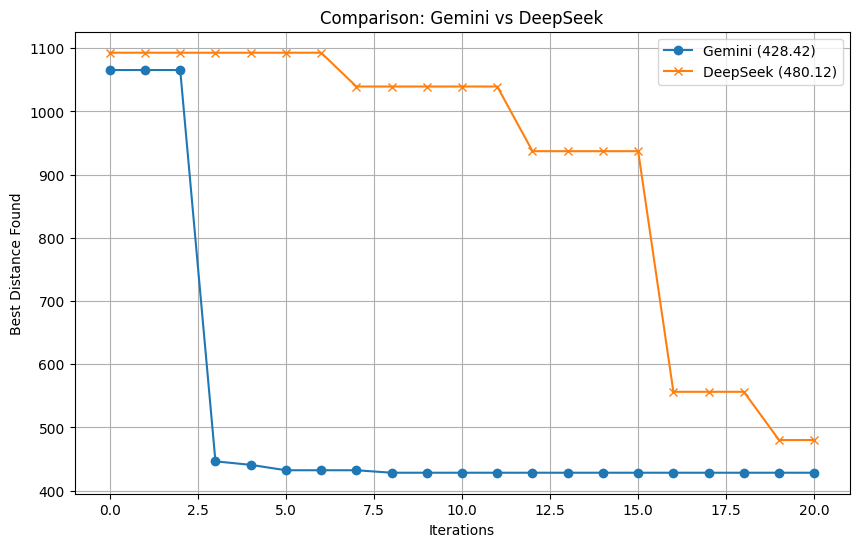

In [ ]:
# Plot optimization progress for Gemini and DeepSeek
plt.figure(figsize=(10, 6))

# Gemini optimization history with markers and final score
plt.plot(history_gemini, label=f'Gemini ({score_gemini:.2f})', marker='o')

# DeepSeek optimization history with markers and final score
plt.plot(history_local, label=f'DeepSeek ({score_local:.2f})', marker='x')

# Plot configuration
plt.title('Comparison: Gemini vs DeepSeek')
plt.xlabel('Iterations')
plt.ylabel('Best Distance Found')
plt.legend()
plt.grid(True)
plt.show()


--- Benchmarking Solvers on 5 Synthetic Circle Instances ---

Problem 1: Circle (N=20), Optimal Score ~ 625.74
  > Gemini    : Score=625.74 | Gap=-0.00% | Time=0.1877s
  > DeepSeek  : Score=625.74 | Gap=-0.00% | Time=0.0002s

Problem 2: Circle (N=25), Optimal Score ~ 626.67
  > Gemini    : Score=626.67 | Gap=0.00% | Time=0.2850s
  > DeepSeek  : Score=626.67 | Gap=-0.00% | Time=0.0002s

Problem 3: Circle (N=30), Optimal Score ~ 627.17
  > Gemini    : Score=627.17 | Gap=-0.00% | Time=0.4629s
  > DeepSeek  : Score=627.17 | Gap=0.00% | Time=0.0002s

Problem 4: Circle (N=35), Optimal Score ~ 627.48
  > Gemini    : Score=627.48 | Gap=0.00% | Time=0.6751s
  > DeepSeek  : Score=627.48 | Gap=0.00% | Time=0.0003s

Problem 5: Circle (N=40), Optimal Score ~ 627.67
  > Gemini    : Score=627.67 | Gap=0.00% | Time=0.9019s
  > DeepSeek  : Score=627.67 | Gap=0.00% | Time=0.0003s


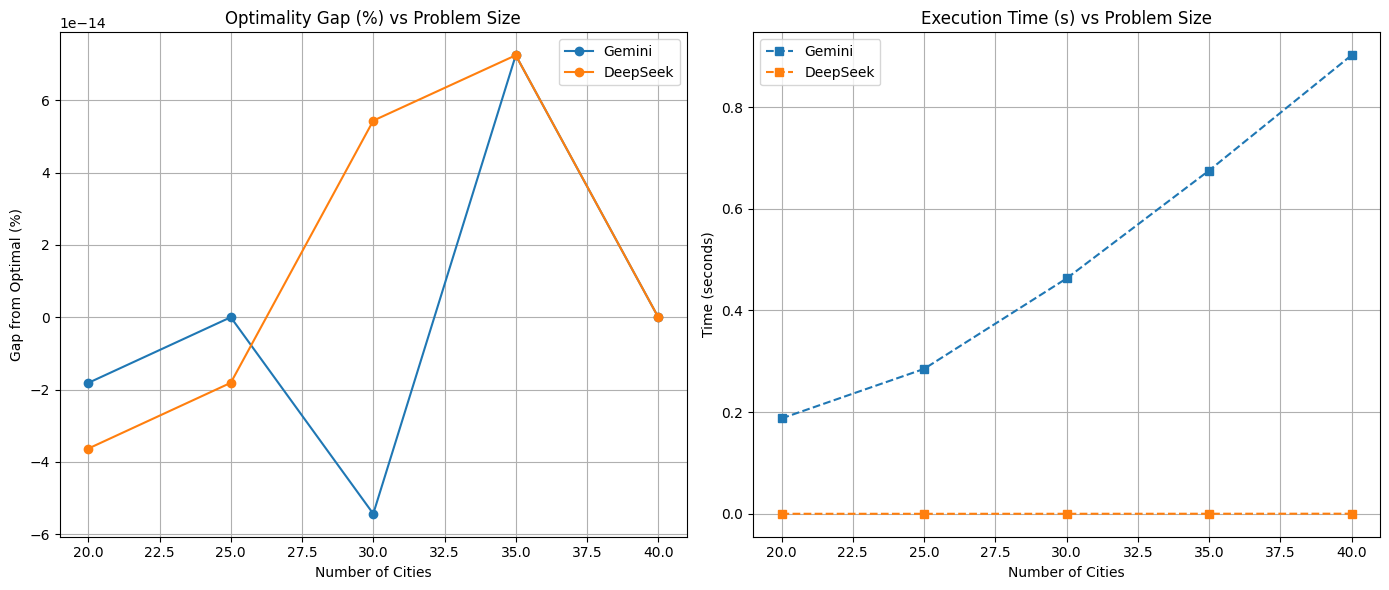

In [ ]:
# Configuration: number of test instances, base problem size, circle radius, solver files
NUM_TEST_INSTANCES = 5
RADIUS = 100.0
BASE_CITIES = 20
SOLVER_FILES = {
    "Gemini": "best_solver_gemini.py",
    "DeepSeek": "best_solver_deepseek.py"
}

# Load the 'solve_tsp' function from a Python file dynamically
def load_solver_func(filepath):
    """Returns the solve_tsp function from the given file, or None if unavailable."""
    try:
        spec = importlib.util.spec_from_file_location("solver_module", filepath)
        module = importlib.util.module_from_spec(spec)
        sys.modules["solver_module"] = module
        spec.loader.exec_module(module)
        return getattr(module, 'solve_tsp', None)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# Generate cities on a circle with computed distance matrix and theoretical optimal tour
def generate_circle_problem(num_cities, radius=100.0):
    angles = np.linspace(0, 2*np.pi, num_cities, endpoint=False)
    coordinates = np.column_stack((radius * np.cos(angles), radius * np.sin(angles)))
    dist_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            dist_matrix[i][j] = np.linalg.norm(coordinates[i] - coordinates[j])
    side_length = 2 * radius * np.sin(np.pi / num_cities)
    optimal_score = side_length * num_cities
    return coordinates, dist_matrix, optimal_score

# Evaluate a candidate tour: return total distance or inf if invalid
def evaluate_route(route, dist_matrix):
    n = len(dist_matrix)
    if len(route) != n or len(set(route)) != n:
        return float('inf')
    return sum(dist_matrix[route[i]][route[(i+1)%n]] for i in range(n))

# Main benchmarking loop
results = {name: {'gaps': [], 'times': []} for name in SOLVER_FILES}
problem_sizes = []

print(f"Benchmarking {NUM_TEST_INSTANCES} synthetic circle instances...")

for k in range(NUM_TEST_INSTANCES):
    n_cities = BASE_CITIES + k*5
    problem_sizes.append(n_cities)
    
    coords, dist_matrix, opt_score = generate_circle_problem(n_cities, RADIUS)
    print(f"Problem {k+1}: N={n_cities}, Optimal Score ~ {opt_score:.2f}")
    
    for name, filepath in SOLVER_FILES.items():
        solver = load_solver_func(filepath)
        if not solver:
            results[name]['gaps'].append(None)
            results[name]['times'].append(None)
            continue
        
        start_time = time.time()
        try:
            route = solver(dist_matrix)
            score = evaluate_route(route, dist_matrix)
            elapsed = time.time() - start_time
            gap = ((score - opt_score)/opt_score)*100
            results[name]['gaps'].append(gap)
            results[name]['times'].append(elapsed)
            print(f"  {name:<10}: Score={score:.2f} | Gap={gap:.2f}% | Time={elapsed:.4f}s")
        except Exception as e:
            print(f"  {name:<10}: FAILED ({e})")
            results[name]['gaps'].append(None)
            results[name]['times'].append(None)

# Visualization of optimality gap and execution time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot optimality gap
for name, data in results.items():
    valid_indices = [i for i,v in enumerate(data['gaps']) if v is not None]
    if valid_indices:
        x = [problem_sizes[i] for i in valid_indices]
        y = [data['gaps'][i] for i in valid_indices]
        ax1.plot(x, y, marker='o', label=name)
ax1.set_title("Optimality Gap (%) vs Problem Size")
ax1.set_xlabel("Number of Cities")
ax1.set_ylabel("Gap from Optimal (%)")
ax1.grid(True)
ax1.legend()

# Plot execution time
for name, data in results.items():
    valid_indices = [i for i,v in enumerate(data['times']) if v is not None]
    if valid_indices:
        x = [problem_sizes[i] for i in valid_indices]
        y = [data['times'][i] for i in valid_indices]
        ax2.plot(x, y, marker='s', linestyle='--', label=name)
ax2.set_title("Execution Time (s) vs Problem Size")
ax2.set_xlabel("Number of Cities")
ax2.set_ylabel("Time (seconds)")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()